<a href="https://colab.research.google.com/github/EpicOne1/7318-Deep-Learning/blob/master/VGG11_FC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import torch
import torchvision
import torchvision.transforms as transforms

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [23]:
device

device(type='cuda', index=0)

In [24]:
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [25]:
import torch.nn as nn
import torch.nn.functional as F

# VGG11 ConvNet configuration is 'A', 'M' = Max pooling layer
# B is reduced size networks 
cfgs = {'D': [64, 'M', 128, 'M', 256, 256, 'M']}

def make_layers(cfg):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else: 
            # add convolutional layer and Batch Norm
            layers.append(nn.Conv2d(in_channels=in_channels,
                                    out_channels=v,
                                    kernel_size=3,
                                    stride=1,
                                    padding=1,
                                    bias=True))
            layers.append(nn.BatchNorm2d(v))
            layers.append(nn.ReLU(inplace=True))
            in_channels = v
    return nn.Sequential(*layers)



class VGG(nn.Module):
    # 10 classes
    def __init__(self, name, num_classes=10):
        super(VGG, self).__init__()
        # VGG11_D
        cfg = cfgs[name]
        self.layers = make_layers(cfg)
        self.avgpool = nn.AdaptiveAvgPool2d((3,3)) # change 7x7 to 3x3
        self.classifier = nn.Sequential(
            nn.Linear(256*3*3, num_classes), #fc1
            # nn.ReLU(True),
            # nn.Dropout(),
            # nn.Linear(512,num_classes), #fc2
            # nn.ReLU(True),
            # nn.Dropout(),
            # nn.Linear(256, num_classes) #fc3
        )
            
    def forward(self,x):
        x = self.layers(x)
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        return x
    
def VGG11_D():
  return VGG('D')

    
net = VGG11_D().to(device)
print(net)

VGG(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kern

In [26]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum=0.9)

In [27]:
training_acc = []
test_acc = []
train_loss = []

for epoch in range(100): # loop over the dataset 100 times (1 epoch = all training samples)
    
    running_loss = 0.0
    # ith mini-batch, 1 mini-batch has 64 training samples 
    # batch size = 64
    for i, data in enumerate(trainloader, 0):
        # get inputs; the data is presented as a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward 
        outputs = net(inputs)
        # calculate loss
        loss = criterion(outputs, labels)
        # backward
        loss.backward()
        # update parameter (optimize)
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i%125 == 124: # print every 125 mini-batches, 125*64 samples
            print('[%d, %5d] loss: %.3f' %
                 (epoch+1, i+1, running_loss/125))
            # every 125 mini-batches, reset running_loss    
            # because it is accumulated for each mini-batches
            train_loss.append(running_loss/125)
            running_loss = 0.0
            
    
    # training and test accuracy for each epoch
    # train
    correct = 0
    total = 0
    # no_grad(): reduce memory consumption for computations
    with torch.no_grad():
        # load data from training set
        for data in trainloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        training_acc.append(100 * correct / total)
        
    # test     
    correct = 0
    total = 0
    # no_grad(): reduce memory consumption for computations
    with torch.no_grad():
        # load data from test set
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        test_acc.append(100 * correct / total)    
        
print("Finished Training")

[1,   125] loss: 1.724
[1,   250] loss: 1.362
[1,   375] loss: 1.214
[1,   500] loss: 1.161
[1,   625] loss: 1.088
[1,   750] loss: 1.033
[2,   125] loss: 0.942
[2,   250] loss: 0.919
[2,   375] loss: 0.890
[2,   500] loss: 0.841
[2,   625] loss: 0.822
[2,   750] loss: 0.836
[3,   125] loss: 0.735
[3,   250] loss: 0.705
[3,   375] loss: 0.714
[3,   500] loss: 0.733
[3,   625] loss: 0.688
[3,   750] loss: 0.689
[4,   125] loss: 0.619
[4,   250] loss: 0.589
[4,   375] loss: 0.618
[4,   500] loss: 0.602
[4,   625] loss: 0.606
[4,   750] loss: 0.599
[5,   125] loss: 0.522
[5,   250] loss: 0.505
[5,   375] loss: 0.523
[5,   500] loss: 0.517
[5,   625] loss: 0.536
[5,   750] loss: 0.519
[6,   125] loss: 0.411
[6,   250] loss: 0.451
[6,   375] loss: 0.450
[6,   500] loss: 0.447
[6,   625] loss: 0.452
[6,   750] loss: 0.465
[7,   125] loss: 0.378
[7,   250] loss: 0.373
[7,   375] loss: 0.385
[7,   500] loss: 0.389
[7,   625] loss: 0.392
[7,   750] loss: 0.389
[8,   125] loss: 0.307
[8,   250] 

KeyboardInterrupt: ignored

VGG11_2FC

In [8]:
training_acc

[59.396,
 68.08,
 72.194,
 76.616,
 79.676,
 82.074,
 84.004,
 85.824,
 87.866,
 89.192,
 90.012,
 91.478,
 93.434,
 93.796,
 94.326,
 95.706,
 96.682,
 97.674,
 97.514,
 98.57]

In [9]:
test_acc

[58.22,
 66.8,
 70.26,
 73.7,
 74.6,
 76.25,
 77.62,
 77.74,
 78.83,
 79.51,
 78.96,
 79.6,
 79.86,
 79.87,
 79.22,
 80.47,
 80.84,
 80.76,
 81.27,
 80.89]

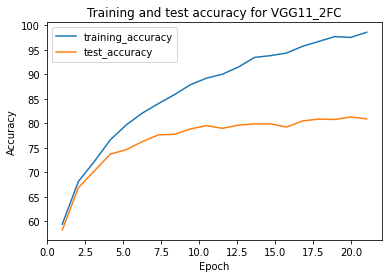

In [10]:
import matplotlib.pyplot as plt
import numpy as np
epoch = np.linspace(1,21,20)
fig = plt.figure()
plt.plot(epoch, training_acc, label = 'training_accuracy')
plt.plot(epoch, test_acc, label = 'test_accuracy')
plt.title('Training and test accuracy for VGG11_2FC')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
fig.savefig('VGG11_2FC_result.jpg')

VGG11_FC

In [18]:
training_acc

[68.554,
 75.418,
 79.796,
 82.196,
 84.244,
 88.786,
 90.738,
 90.516,
 94.32,
 95.578,
 97.328,
 96.972,
 98.712,
 99.126,
 99.43,
 99.71,
 99.872,
 99.974,
 99.974,
 99.998]

In [19]:
test_acc

[66.72,
 71.97,
 74.65,
 76.22,
 76.46,
 78.97,
 78.72,
 78.59,
 80.27,
 80.35,
 80.38,
 79.9,
 80.88,
 81.1,
 81.54,
 81.59,
 82.07,
 82.55,
 82.11,
 82.39]

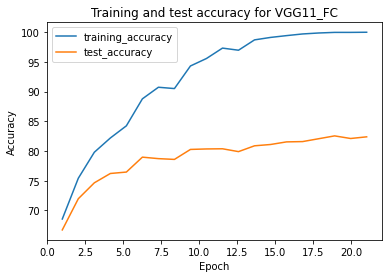

In [20]:
import matplotlib.pyplot as plt
import numpy as np
epoch = np.linspace(1,21,20)
fig = plt.figure()
plt.plot(epoch, training_acc, label = 'training_accuracy')
plt.plot(epoch, test_acc, label = 'test_accuracy')
plt.title('Training and test accuracy for VGG11_FC')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
fig.savefig('VGG11_FC_result.jpg')

In [28]:
training_acc

[64.536,
 74.844,
 77.876,
 80.822,
 85.912,
 87.644,
 89.888,
 92.27,
 93.614,
 95.818,
 96.24,
 97.9,
 98.528,
 99.466,
 99.63,
 99.894,
 99.966,
 99.968,
 99.982,
 99.982,
 100.0,
 99.998,
 99.998,
 100.0,
 100.0,
 100.0]

In [29]:
test_acc

[62.75,
 71.44,
 72.67,
 74.61,
 77.49,
 77.61,
 78.29,
 78.92,
 79.72,
 79.85,
 79.47,
 80.82,
 80.94,
 81.79,
 82.44,
 82.19,
 83.05,
 82.95,
 82.73,
 82.63,
 82.67,
 82.98,
 83.08,
 83.01,
 83.04,
 82.93]

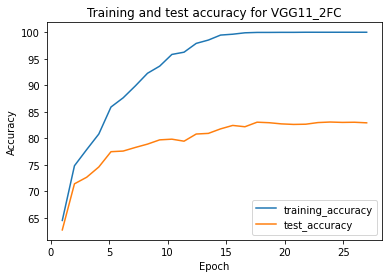

In [30]:
import matplotlib.pyplot as plt
import numpy as np
epoch = np.linspace(1,27,26)
fig = plt.figure()
plt.plot(epoch, training_acc, label = 'training_accuracy')
plt.plot(epoch, test_acc, label = 'test_accuracy')
plt.title('Training and test accuracy for VGG11_2FC')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
fig.savefig('VGG11_2FC_result.jpg')